LRRU filled 算法

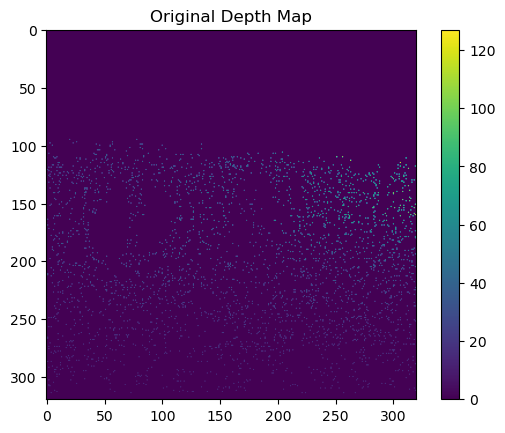

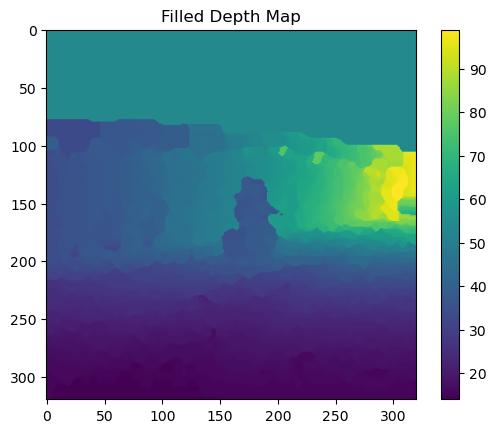

In [2]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import label
# 你需要定义的卷积核
DIAMOND_KERNEL_5 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
FULL_KERNEL_5 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
FULL_KERNEL_7 = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
FULL_KERNEL_31 = cv2.getStructuringElement(cv2.MORPH_RECT, (31, 31))
FULL_KERNEL_13 = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))

def fill_in_fast_tensor(depth_tensor, max_depth=100.0, custom_kernel=DIAMOND_KERNEL_5,
                        extrapolate=False, blur_type='bilateral'):
    """Fast, in-place depth completion for tensor.

    Args:
        depth_tensor: projected depths tensor with shape [b, c=1, h, w]
        max_depth: max depth value for inversion
        custom_kernel: kernel to apply initial dilation
        extrapolate: whether to extrapolate by extending depths to top of
            the frame, and applying a 31x31 full kernel dilation
        blur_type:
            'bilateral' - preserves local structure (recommended)
            'gaussian' - provides lower RMSE

    Returns:
        depth_tensor: dense depth tensor with same shape [b, c=1, h, w]
    """
    depth_tensor_np = depth_tensor.squeeze(1).cpu().numpy()  # Convert to numpy array with shape [b, h, w]

    for i in range(depth_tensor_np.shape[0]):  # Iterate over the batch
        depth_map = depth_tensor_np[i]

        valid_pixels = (depth_map > 0.1)
        depth_map[valid_pixels] = max_depth - depth_map[valid_pixels]

        depth_map = cv2.dilate(depth_map, custom_kernel)

        depth_map = cv2.morphologyEx(depth_map, cv2.MORPH_CLOSE, FULL_KERNEL_5)

        empty_pixels = (depth_map < 0.1)
        dilated = cv2.dilate(depth_map, FULL_KERNEL_7)
        depth_map[empty_pixels] = dilated[empty_pixels]

        if extrapolate:
            top_row_pixels = np.argmax(depth_map > 0.1, axis=0)
            top_pixel_values = depth_map[top_row_pixels, range(depth_map.shape[1])]

            for pixel_col_idx in range(depth_map.shape[1]):
                depth_map[0:top_row_pixels[pixel_col_idx], pixel_col_idx] = \
                    top_pixel_values[pixel_col_idx]

        empty_pixels = depth_map < 0.1
        dilated = cv2.dilate(depth_map, FULL_KERNEL_31)
        depth_map[empty_pixels] = dilated[empty_pixels]

        depth_map = depth_map.astype('float32')
        depth_map = cv2.medianBlur(depth_map, 5)
        depth_map = depth_map.astype('float64')

        if blur_type == 'bilateral':
            depth_map = depth_map.astype('float32')
            depth_map = cv2.bilateralFilter(depth_map, 5, 1.5, 2.0)
            depth_map = depth_map.astype('float64')
        elif blur_type == 'gaussian':
            valid_pixels = (depth_map > 0.1)
            blurred = cv2.GaussianBlur(depth_map, (5, 5), 0)
            depth_map[valid_pixels] = blurred[valid_pixels]

        valid_pixels = (depth_map > 0.1)
        depth_map[valid_pixels] = max_depth - depth_map[valid_pixels]

        mask = (depth_map <= 0.1)
        if np.sum(mask) != 0:
            labeled_array, num_features = label(mask)
            for j in range(num_features):
                index = j + 1
                m = (labeled_array == index)
                m_dilate1 = cv2.dilate(1.0 * m, FULL_KERNEL_7)
                m_dilate2 = cv2.dilate(1.0 * m, FULL_KERNEL_13)
                m_diff = m_dilate2 - m_dilate1
                v = np.mean(depth_map[m_diff > 0])
                depth_map = np.ma.array(depth_map, mask=m_dilate1, fill_value=v)
                depth_map = depth_map.filled()
                depth_map = np.array(depth_map)

        depth_tensor_np[i] = depth_map

    depth_tensor_filled = torch.from_numpy(depth_tensor_np).unsqueeze(1).to(depth_tensor.device)

    return depth_tensor_filled

def load_depth_image(file_path):
    """Load depth image from file."""
    depth_image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    if depth_image is None:
        raise FileNotFoundError(f"Depth image file not found: {file_path}")
    return depth_image

def visualize_depth(depth_map, title="Depth Map"):
    """Visualize depth map."""
    plt.imshow(depth_map, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

# 加载深度图像文件
file_path = '/data1/Chenbingyuan/Depth-Completion/g2_dataset/KITTI/point/point_0.1/KITTI_gt/2011_09_26_drive_0002_0000000005_image_02.png'
depth_image = load_depth_image(file_path)

# 将深度图像转换为 PyTorch 张量
depth_tensor = torch.from_numpy(np.expand_dims(np.expand_dims(depth_image, 0), 0)).float()

# 应用深度填充算法
filled_depth_tensor = fill_in_fast_tensor(depth_tensor)

# 转换为 NumPy 数组进行可视化
filled_depth_image = filled_depth_tensor.squeeze().cpu().numpy()

# 可视化结果
visualize_depth(depth_image, title="Original Depth Map")
visualize_depth(filled_depth_image, title="Filled Depth Map")
